In [63]:
# Install necessary libraries
!pip install imbalanced-learn xgboost
!pip install umap-learn


# Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
data = pd.read_csv(url)


In [64]:
# Data exploration
print("Dataset Information:")
print(data.info())
print("\nFirst five rows of the dataset:")
print(data.head())
print("\nDataset Summary:")
print(data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# The only categorical column needing encoding is 'Month'
categorical_features = ['Month']
numerical_features = [
    'Administrative', 'Administrative_Duration', 'Informational',
    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'
]
target_variable = 'Revenue'

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  T

In [65]:
# Define features and target
X = data.drop(columns=['Revenue'])
y = data['Revenue']


In [66]:
# One-hot encoding for 'Month'
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_month = pd.DataFrame(
    encoder.fit_transform(data[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features)
)
data = pd.concat([data.drop(columns=categorical_features), encoded_month], axis=1)


In [67]:
# Standardize numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [68]:
# Split the data
X = data.drop(columns=[target_variable])
y = data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [70]:
# Ensure all columns in X_train are numeric
if not np.issubdtype(X_train.dtypes, np.number):
    # Identify non-numeric columns
    non_numeric_columns = X_train.select_dtypes(include=['object']).columns
    print(f"Non-numeric columns found: {non_numeric_columns.tolist()}")

    # Apply one-hot encoding to non-numeric columns
    X_train = pd.get_dummies(X_train, columns=non_numeric_columns)
    X_test = pd.get_dummies(X_test, columns=non_numeric_columns)

    # Ensure X_train and X_test have the same columns after encoding
    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)  # Fill any missing columns in X_test with zeros

# Apply SMOTE after ensuring numeric data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


Non-numeric columns found: ['VisitorType']


In [71]:
# Display class distribution
print("\nClass distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())



Class distribution before SMOTE:
Revenue
False    7295
True     1336
Name: count, dtype: int64

Class distribution after SMOTE:
Revenue
False    7295
True     7295
Name: count, dtype: int64


In [72]:
# Define a function for model evaluation
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Non-numeric columns found: ['VisitorType']


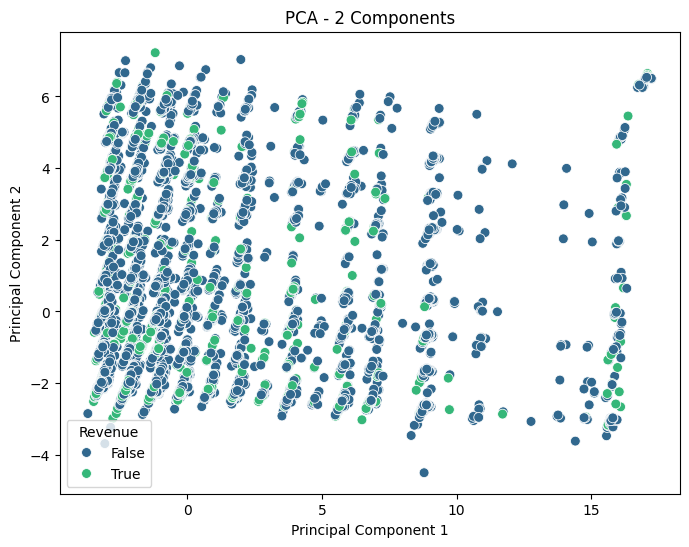

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all features are numeric
if not np.issubdtype(X.dtypes, np.number):
    # Identify non-numeric columns
    non_numeric_columns = X.select_dtypes(include=['object']).columns
    print(f"Non-numeric columns found: {non_numeric_columns.tolist()}")

    # Apply one-hot encoding to non-numeric columns
    X = pd.get_dummies(X, columns=non_numeric_columns)

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Visualize PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=50)
plt.title('PCA - 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Revenue')
plt.show()


Non-numeric columns found: []


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


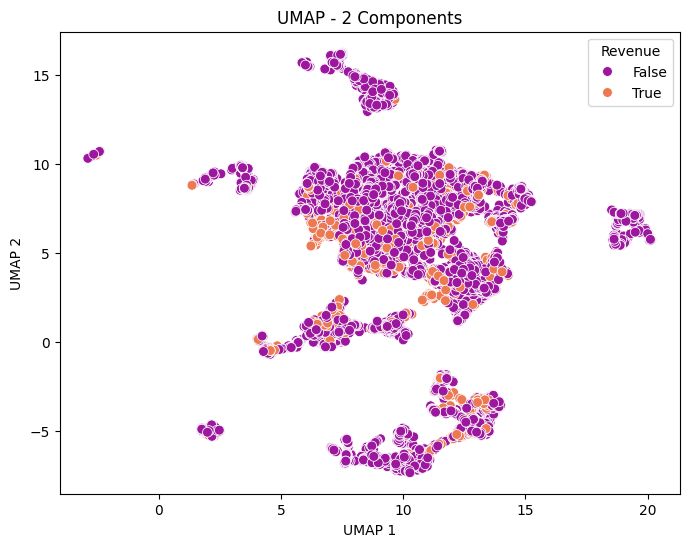

In [75]:
from umap import UMAP

# Ensure all features are numeric (repeating the step to make UMAP independent)
if not np.issubdtype(X.dtypes, np.number):
    # Identify non-numeric columns
    non_numeric_columns = X.select_dtypes(include=['object']).columns
    print(f"Non-numeric columns found: {non_numeric_columns.tolist()}")

    # Apply one-hot encoding to non-numeric columns
    X = pd.get_dummies(X, columns=non_numeric_columns)

# UMAP
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# Visualize UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='plasma', s=50)
plt.title('UMAP - 2 Components')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Revenue')
plt.show()


Non-numeric columns found: []


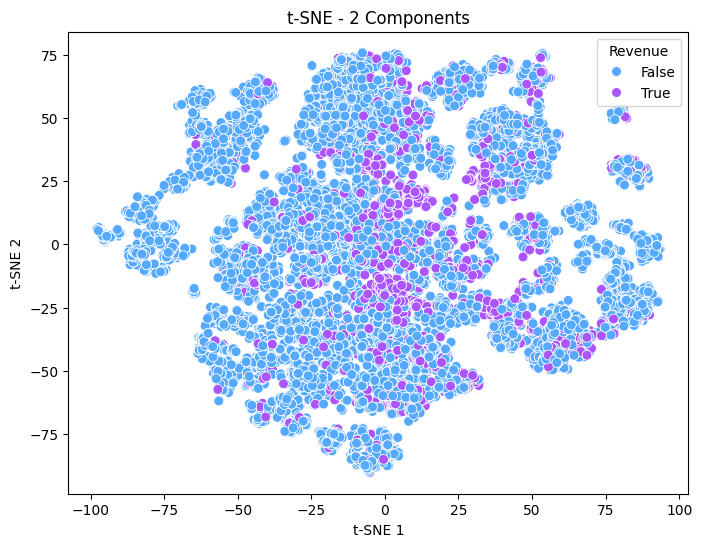

In [76]:
from sklearn.manifold import TSNE

# Ensure all features are numeric (repeating the step to make t-SNE independent)
if not np.issubdtype(X.dtypes, np.number):
    # Identify non-numeric columns
    non_numeric_columns = X.select_dtypes(include=['object']).columns
    print(f"Non-numeric columns found: {non_numeric_columns.tolist()}")

    # Apply one-hot encoding to non-numeric columns
    X = pd.get_dummies(X, columns=non_numeric_columns)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='cool', s=50)
plt.title('t-SNE - 2 Components')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Revenue')
plt.show()


<ipython-input-77-5901dcbed2f1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='Administrative', palette='pink')


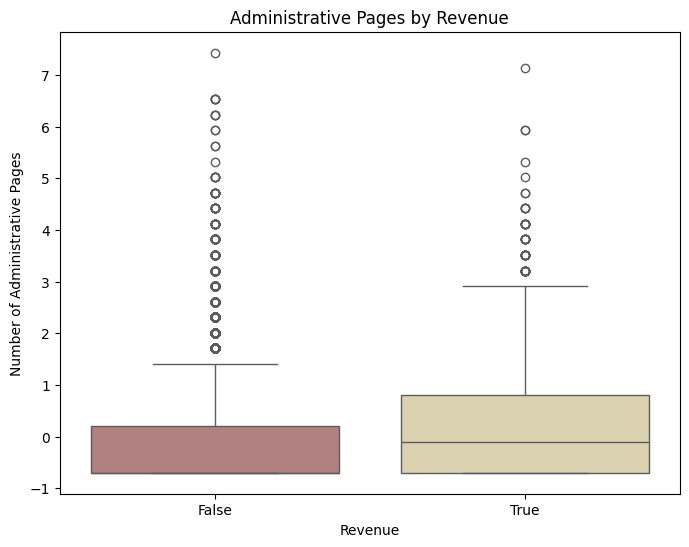

In [77]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='Administrative', palette='pink')
plt.title('Administrative Pages by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Number of Administrative Pages')
plt.show()


<ipython-input-78-5f95dee3ddf9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='Administrative_Duration', palette='pink')


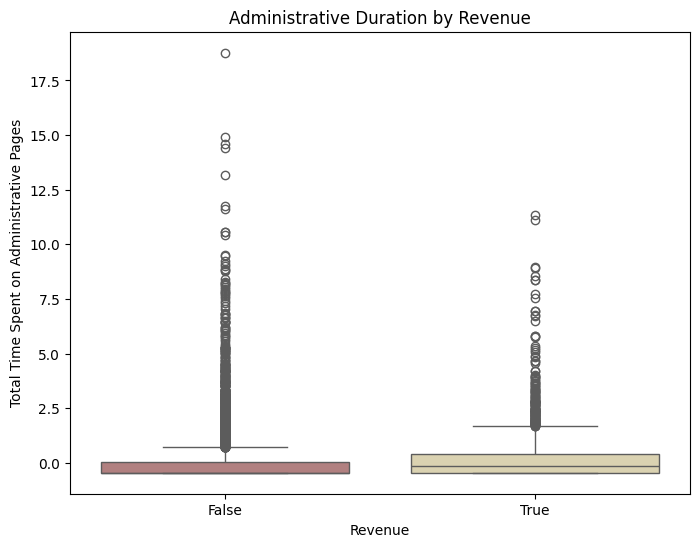

In [78]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='Administrative_Duration', palette='pink')
plt.title('Administrative Duration by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Total Time Spent on Administrative Pages')
plt.show()


<ipython-input-79-ad0ecc99df3e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='Informational', palette='pink')


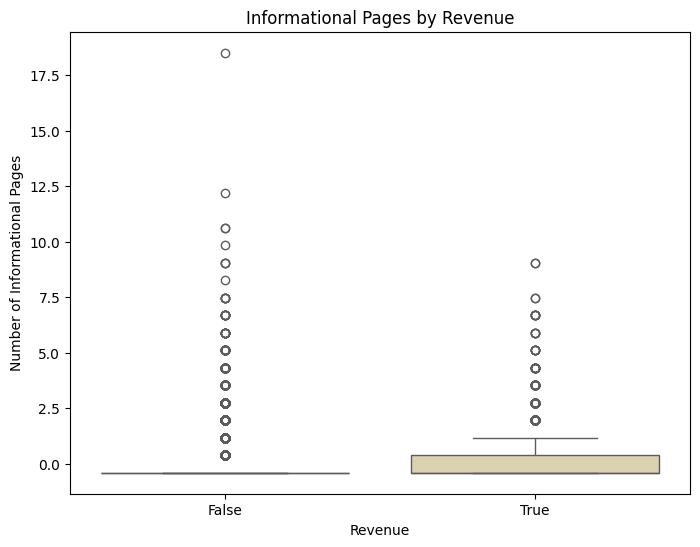

In [79]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='Informational', palette='pink')
plt.title('Informational Pages by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Number of Informational Pages')
plt.show()


<ipython-input-80-706b52027d39>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='Informational_Duration', palette='pink')


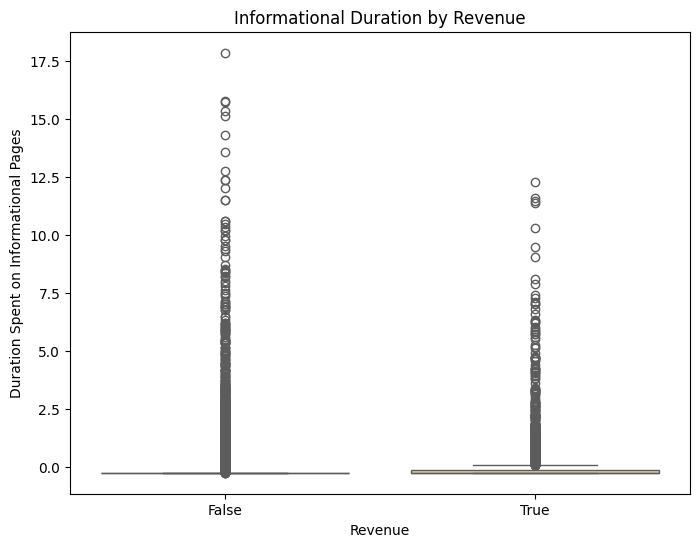

In [80]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='Informational_Duration', palette='pink')
plt.title('Informational Duration by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Duration Spent on Informational Pages')
plt.show()


<ipython-input-81-d1430eed8d80>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='ProductRelated', palette='pink')


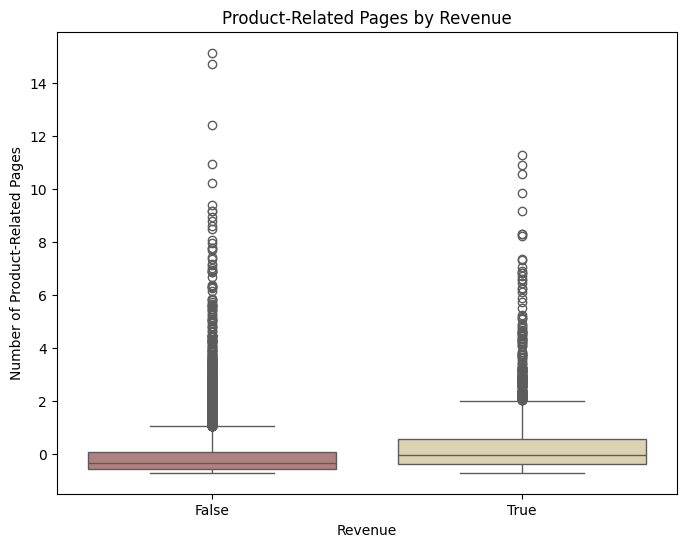

In [81]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='ProductRelated', palette='pink')
plt.title('Product-Related Pages by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Number of Product-Related Pages')
plt.show()


<ipython-input-82-10b145447a27>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Revenue', y='ProductRelated_Duration', palette='pink')


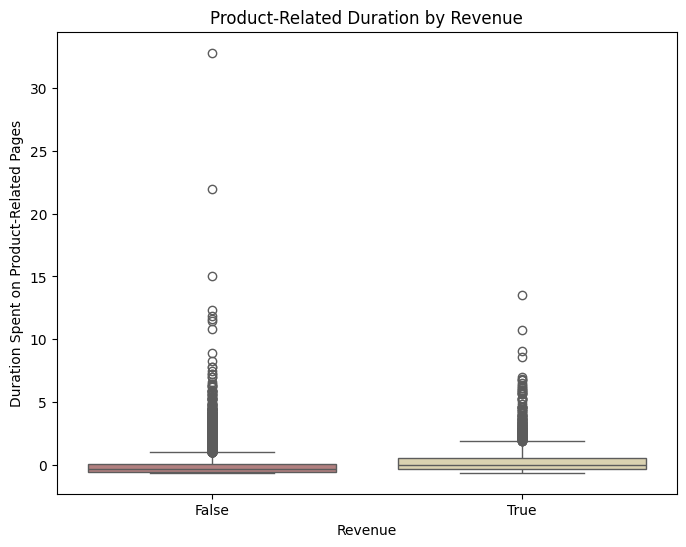

In [82]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Revenue', y='ProductRelated_Duration', palette='pink')
plt.title('Product-Related Duration by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Duration Spent on Product-Related Pages')
plt.show()


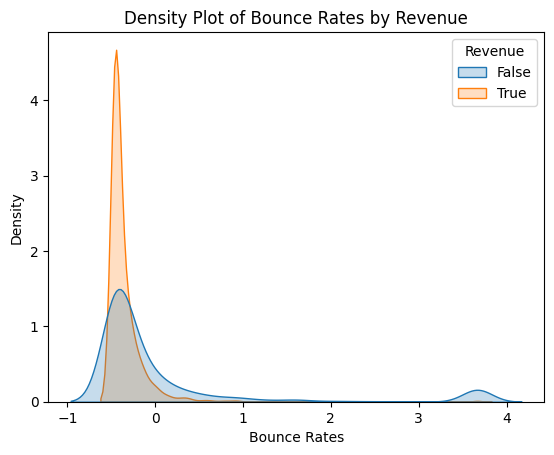

In [83]:
sns.kdeplot(data=data, x='BounceRates', hue='Revenue', fill=True, common_norm=False)
plt.title('Density Plot of Bounce Rates by Revenue')
plt.xlabel('Bounce Rates')
plt.ylabel('Density')
plt.show()


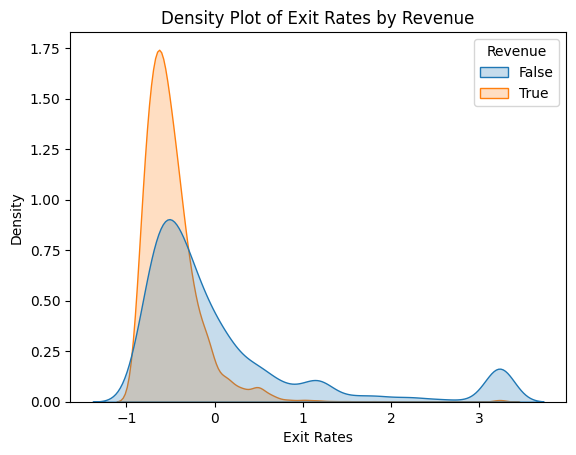

In [84]:
sns.kdeplot(data=data, x='ExitRates', hue='Revenue', fill=True, common_norm=False)
plt.title('Density Plot of Exit Rates by Revenue')
plt.xlabel('Exit Rates')
plt.ylabel('Density')
plt.show()


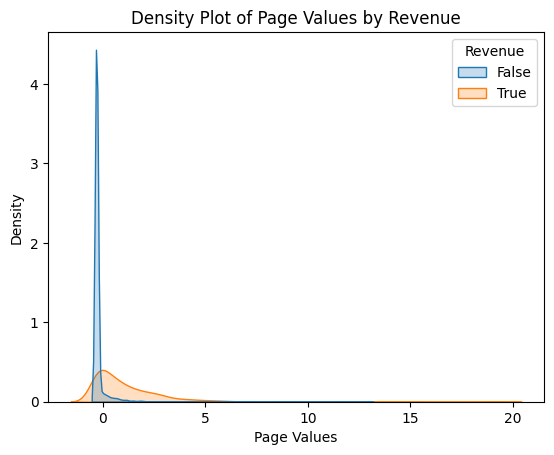

In [85]:
sns.kdeplot(data=data, x='PageValues', hue='Revenue', fill=True, common_norm=False)
plt.title('Density Plot of Page Values by Revenue')
plt.xlabel('Page Values')
plt.ylabel('Density')
plt.show()


<ipython-input-86-265aa0b52c43>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')
<ipython-input-86-265aa0b52c43>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')


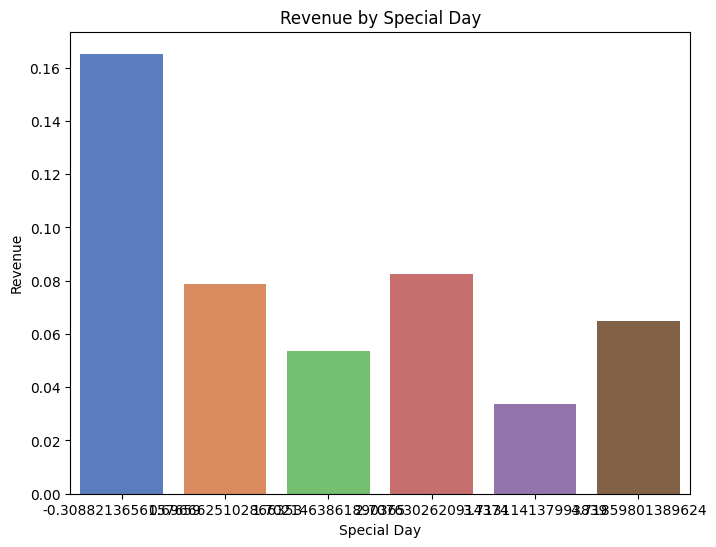

In [86]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')
plt.title('Revenue by Special Day')
plt.xlabel('Special Day')
plt.ylabel('Revenue')
plt.show()


<ipython-input-87-265aa0b52c43>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')
<ipython-input-87-265aa0b52c43>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')


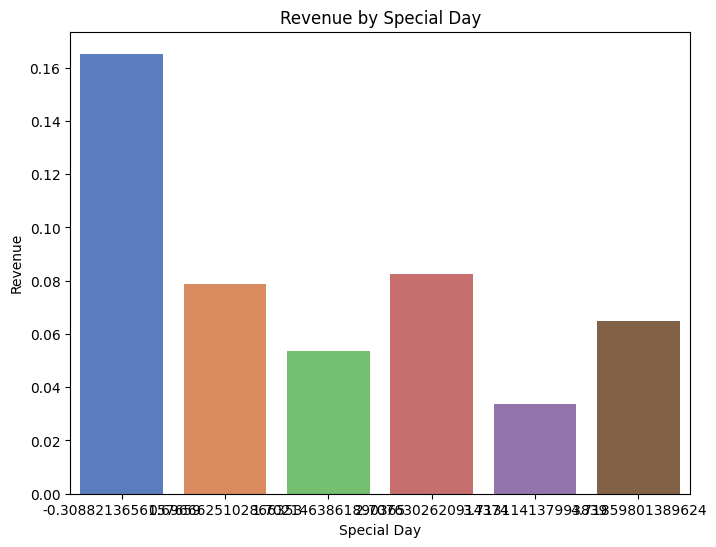

In [87]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='SpecialDay', y='Revenue', ci=None, palette='muted')
plt.title('Revenue by Special Day')
plt.xlabel('Special Day')
plt.ylabel('Revenue')
plt.show()


<ipython-input-92-23b87b899da4>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=browser_data, x='Browser', y='Revenue', ci=None, palette='muted')
<ipython-input-92-23b87b899da4>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=browser_data, x='Browser', y='Revenue', ci=None, palette='muted')


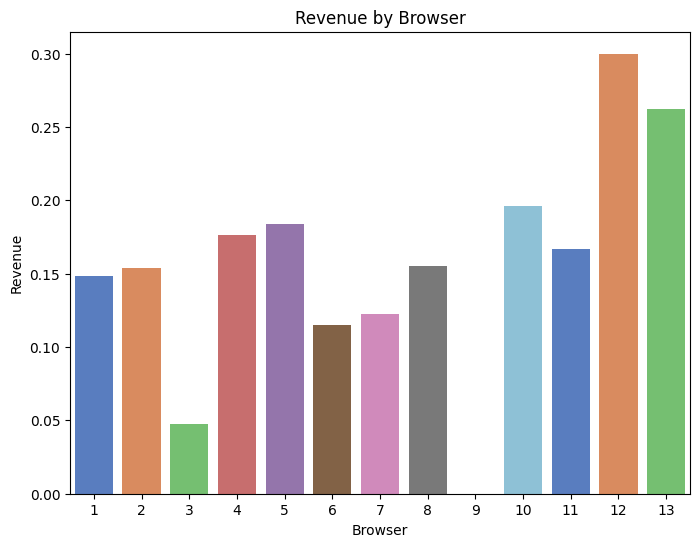

In [92]:
# Check if 'Browser' is in the dataset
if 'Browser' in data.columns:
    # Use the original column if available
    browser_data = data[['Browser', 'Revenue']]
else:
    # Recreate 'Browser' from one-hot encoded columns
    browser_columns = [col for col in data.columns if col.startswith('Browser_')]
    browser_data = data[browser_columns + ['Revenue']]

    # Find the most likely browser from one-hot encoded columns
    browser_data['Browser'] = (
        browser_data[browser_columns]
        .idxmax(axis=1)  # Find the column name with the max value
        .str.extract(r'(\d+)')  # Extract the numeric suffix
        .fillna(0)  # Replace NaN with 0
        .astype(int)  # Convert to integer
    )

# Bar plot of Browser by Revenue
plt.figure(figsize=(8, 6))
sns.barplot(data=browser_data, x='Browser', y='Revenue', ci=None, palette='muted')
plt.title('Revenue by Browser')
plt.xlabel('Browser')
plt.ylabel('Revenue')
plt.show()


<ipython-input-93-f1b486e1df1c>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=region_data, x='Region', y='Revenue', ci=None, palette='muted')
<ipython-input-93-f1b486e1df1c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_data, x='Region', y='Revenue', ci=None, palette='muted')


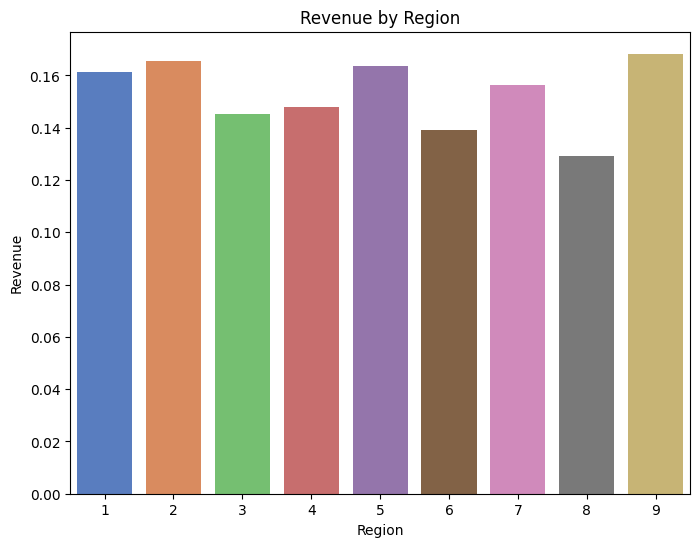

In [93]:
# Check if 'Region' is in the dataset
if 'Region' in data.columns:
    # Use the original column if available
    region_data = data[['Region', 'Revenue']]
else:
    # Recreate 'Region' from one-hot encoded columns
    region_columns = [col for col in data.columns if col.startswith('Region_')]
    region_data = data[region_columns + ['Revenue']]

    # Find the most likely region from one-hot encoded columns
    region_data['Region'] = (
        region_data[region_columns]
        .idxmax(axis=1)  # Find the column name with the max value
        .str.extract(r'(\d+)')  # Extract the numeric suffix
        .fillna(0)  # Replace NaN with 0
        .astype(int)  # Convert to integer
    )

# Bar plot of Region by Revenue
plt.figure(figsize=(8, 6))
sns.barplot(data=region_data, x='Region', y='Revenue', ci=None, palette='muted')
plt.title('Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Revenue')
plt.show()


<ipython-input-94-c3b839b20169>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=traffic_data, x='TrafficType', y='Revenue', ci=None, palette='muted')
<ipython-input-94-c3b839b20169>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_data, x='TrafficType', y='Revenue', ci=None, palette='muted')


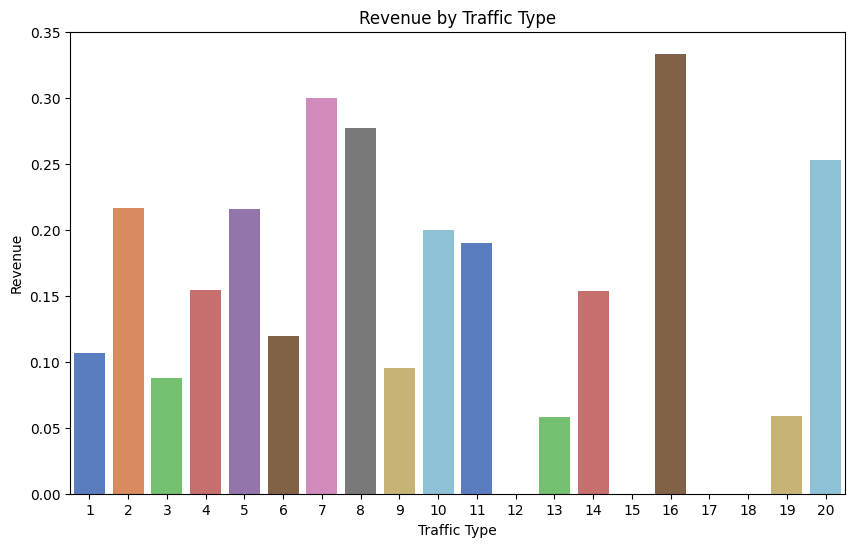

In [94]:
# Check if 'TrafficType' is in the dataset
if 'TrafficType' in data.columns:
    # Use the original column if available
    traffic_data = data[['TrafficType', 'Revenue']]
else:
    # Recreate 'TrafficType' from one-hot encoded columns
    traffic_columns = [col for col in data.columns if col.startswith('TrafficType_')]
    traffic_data = data[traffic_columns + ['Revenue']]

    # Find the most likely traffic type from one-hot encoded columns
    traffic_data['TrafficType'] = (
        traffic_data[traffic_columns]
        .idxmax(axis=1)  # Find the column name with the max value
        .str.extract(r'(\d+)')  # Extract the numeric suffix
        .fillna(0)  # Replace NaN with 0
        .astype(int)  # Convert to integer
    )

# Bar plot of Traffic Type by Revenue
plt.figure(figsize=(10, 6))
sns.barplot(data=traffic_data, x='TrafficType', y='Revenue', ci=None, palette='muted')
plt.title('Revenue by Traffic Type')
plt.xlabel('Traffic Type')
plt.ylabel('Revenue')
plt.show()


Weekend
False    1409
True      499
Name: Revenue, dtype: int64


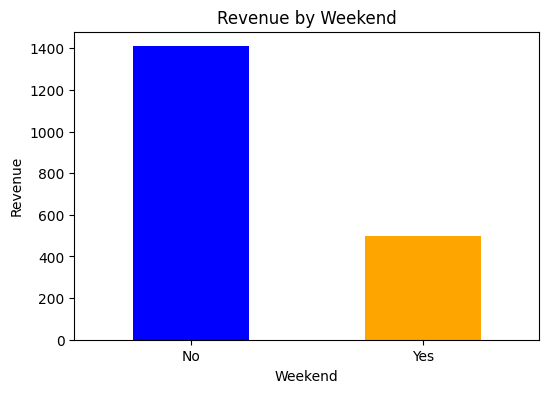

In [96]:
# Check if 'Weekend_True' exists in the data
if 'Weekend_True' in data.columns:
    # Use the column if available
    weekend_revenue = data.groupby('Weekend_True')['Revenue'].sum()
else:
    # Use the original 'Weekend' column if available
    if 'Weekend' in data.columns:
        weekend_revenue = data.groupby('Weekend')['Revenue'].sum()
    else:
        raise KeyError("The 'Weekend' or 'Weekend_True' column is missing from the data.")

# Print the grouped revenue
print(weekend_revenue)

# Bar plot for weekend revenue
plt.figure(figsize=(6, 4))
weekend_revenue.plot(kind='bar', color=['blue', 'orange'])
plt.title('Revenue by Weekend')
plt.xlabel('Weekend')
plt.ylabel('Revenue')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.show()


In [106]:
from sklearn.naive_bayes import CategoricalNB

# Convert data to categorical format (if appropriate for your dataset)
X_train_balanced_categorical = X_train_balanced.astype('int')
X_test_categorical = X_test.astype('int')

# Train Naive Bayes
cat_nb_model = CategoricalNB()
cat_nb_model.fit(X_train_balanced_categorical, y_train_balanced)
evaluate_model(cat_nb_model, X_test_categorical, y_test, "Categorical Naive Bayes")



Categorical Naive Bayes Results:
Confusion Matrix:
[[2309  818]
 [ 155  417]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.74      0.83      3127
        True       0.34      0.73      0.46       572

    accuracy                           0.74      3699
   macro avg       0.64      0.73      0.64      3699
weighted avg       0.84      0.74      0.77      3699

Accuracy: 0.74


In [98]:
# 2. k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_balanced, y_train_balanced)
evaluate_model(knn_model, X_test, y_test, "k-Nearest Neighbors")



k-Nearest Neighbors Results:
Confusion Matrix:
[[2459  668]
 [ 196  376]]

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.79      0.85      3127
        True       0.36      0.66      0.47       572

    accuracy                           0.77      3699
   macro avg       0.64      0.72      0.66      3699
weighted avg       0.84      0.77      0.79      3699

Accuracy: 0.77


In [99]:
# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
evaluate_model(rf_model, X_test, y_test, "Random Forest")



Random Forest Results:
Confusion Matrix:
[[2892  235]
 [ 173  399]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.92      0.93      3127
        True       0.63      0.70      0.66       572

    accuracy                           0.89      3699
   macro avg       0.79      0.81      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Accuracy: 0.89


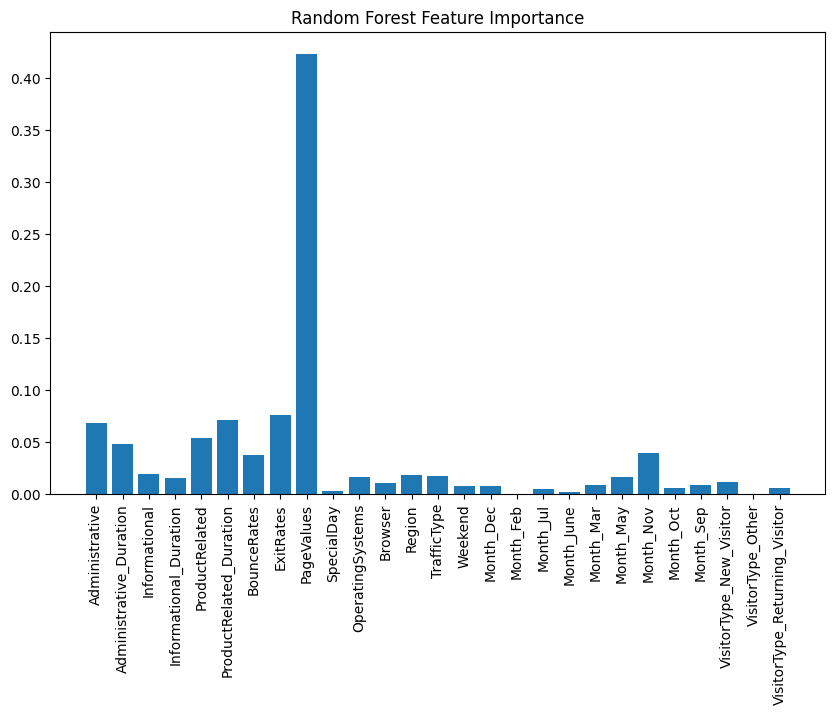

In [100]:
# Feature importance from Random Forest
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
plt.show()

In [101]:
# 4. SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)
evaluate_model(svm_model, X_test, y_test, "Support Vector Machine (Linear)")



Support Vector Machine (Linear) Results:
Confusion Matrix:
[[2796  331]
 [ 163  409]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.92      3127
        True       0.55      0.72      0.62       572

    accuracy                           0.87      3699
   macro avg       0.75      0.80      0.77      3699
weighted avg       0.88      0.87      0.87      3699

Accuracy: 0.87


In [102]:
# 5. XGBoost
dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_params = {
    'objective': 'binary:logistic',
    'eta': 0.3,
    'max_depth': 6,
    'eval_metric': 'auc'
}
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100)
xgb_predictions = xgb_model.predict(dtest)
xgb_pred_labels = (xgb_predictions > 0.5).astype(int)

print("\nXGBoost Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred_labels))
print(f"Accuracy: {accuracy_score(y_test, xgb_pred_labels):.2f}")


XGBoost Results:
Confusion Matrix:
[[2925  202]
 [ 213  359]]

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.94      0.93      3127
        True       0.64      0.63      0.63       572

    accuracy                           0.89      3699
   macro avg       0.79      0.78      0.78      3699
weighted avg       0.89      0.89      0.89      3699

Accuracy: 0.89


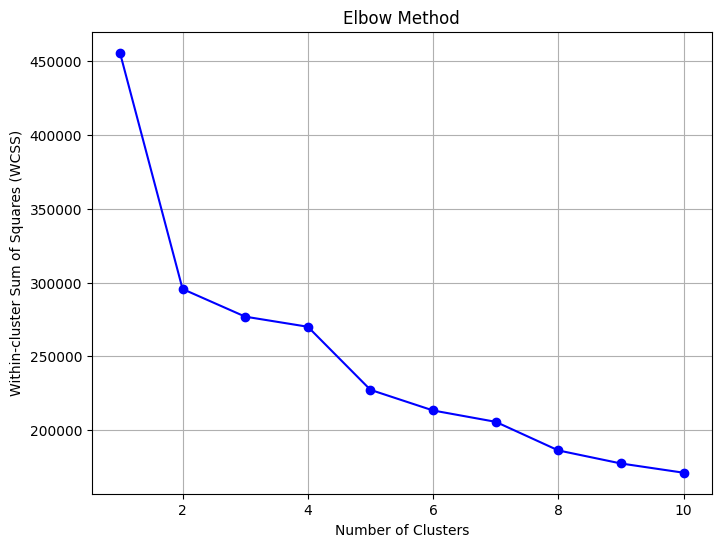

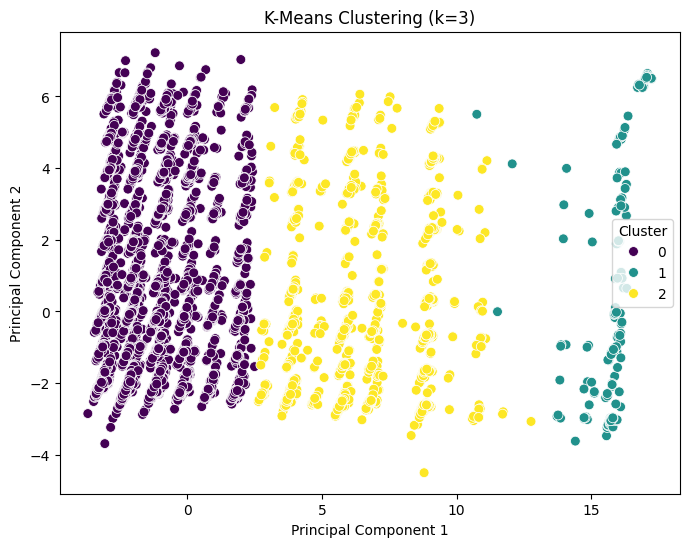

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# K-Means with optimal clusters (k=3, based on Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('K-Means Clustering (k=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


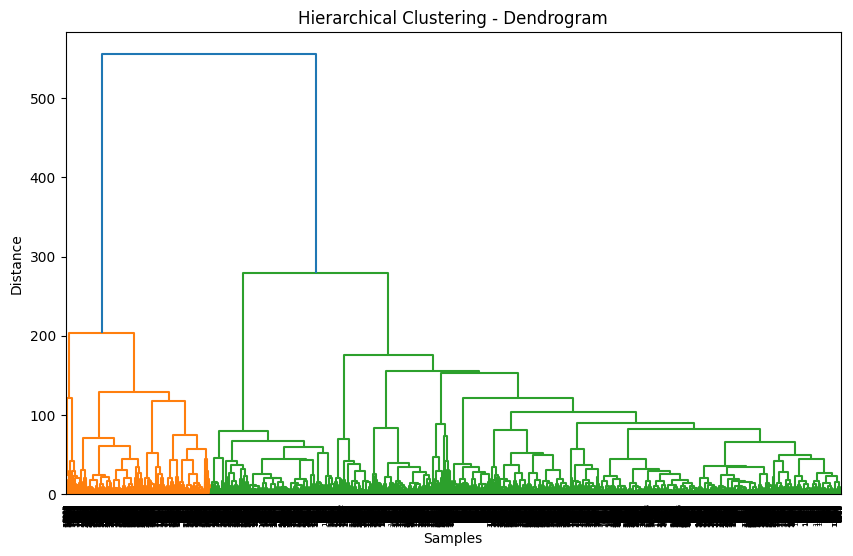

In [109]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linkage_matrix = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering - Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


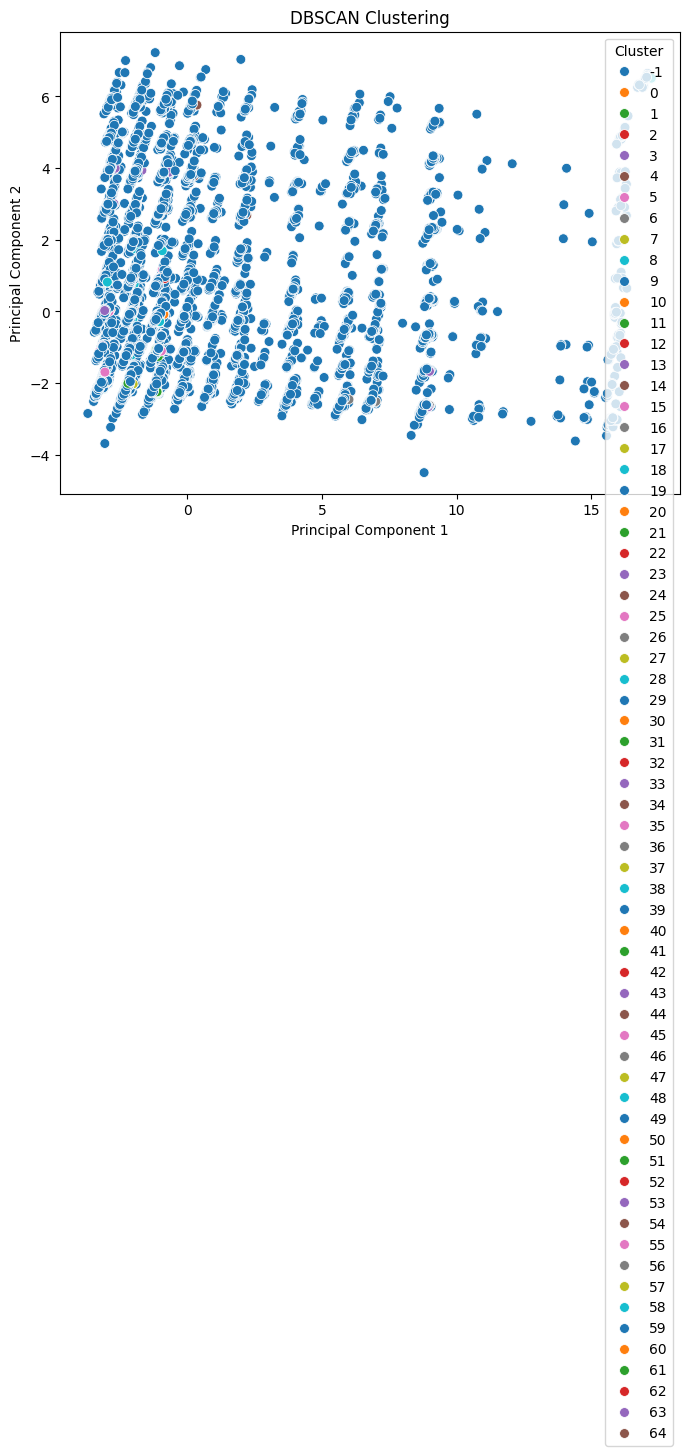

In [115]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data for DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_clusters, palette='tab10', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
